# __ACA dark current map__

In [7]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from chandra_aca import transform
from Chandra.Time import DateTime
import Ska.Numpy
from mica import quaternion
import pyyaks.logger
import numpy.ma as ma
import collections

In [8]:
#   For each image, pick out the 'X's
#
#    8x8                6x6
#      (1)--->
#  (3) XXXXXXXX (4)       .XXXX.
#   |  XXXXXXXX  |        X....X
#   |/ XX....XX  |/       X....X
#      XX....XX           X....X
#      XX....XX           X....X
#      XX....XX           .XXXX.
#      XXXXXXXX
#      XXXXXXXX
#      (2)--->

r = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
     6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7,
     2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5]
c = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
     0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
     0, 0, 0, 0, 1, 1, 1, 1, 6, 6, 6, 6, 7, 7, 7, 7]

rin = [2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5]
cin = [2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5]

#    8x8                6x6
#      (1)--->
#  (3) XXXXXXXX (4)       .XXXX.
#   |  X......X  |        X....X
#   |/ X......X  |/       X....X
#      X......X           X....X
#      X......X           X....X
#      X......X           .XXXX.
#      X......X
#      XXXXXXXX
#      (2)--->

#r = [0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6]
#c = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7]

#rin = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
#       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6]
#cin = [1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6,
#       1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6]

### Functions ###

In [10]:
# frame_data represents one row in Table(slot_data)
# combine slot_data such as IMGROW0, IMGCOL0, IMGRAW, BGDAVG, and a dict of edge pixel vals
def get_frame_row(frame_data, img_size):
    
    frame_row = collections.OrderedDict()
    
    row0 = frame_data['IMGROW0'][0]
    col0 = frame_data['IMGCOL0'][0]
    raw_image = frame_data['IMGRAW'][0]
    
    # Pick out the edge pixels
    frame_row['edge_vals'] = edge_pixels_dict_8x8(raw_image, row0, col0)
        
    frame_row['row0'] = row0
    frame_row['col0'] = col0
    frame_row['raw_img'] = raw_image
    frame_row['bgdavg'] = frame_data['BGDAVG'][0]

    return frame_row


def edge_pixels_dict_8x8(raw_image, row0, col0):

    edge_pixels_dict = collections.OrderedDict()
    
    raw_image = raw_image.reshape(8, 8, order='F')
    
    for rr, cc in zip(r, c): # (r, c) define location of edge pixels (X's)
        r_abs = row0 + rr + shift
        c_abs = col0 + cc + shift
        key = '{}.{}'.format(r_abs, c_abs) # e.g. '781:428'
        edge_pixels_dict[key] = raw_image[rr, cc]
        
    return edge_pixels_dict


def update_deque_dict(abs_coords, deque_dict, frame_row):
    # Consider pixels sampled by dither, with
    # r = (abs_coords.rstart:abs_coords.rend) and c = (abs_coords.cstart:abs_coords.cend)
    #
    # Update deque_dict:
    # 1. extend deque with edge value if we are on the edge
    # 2. extend deque with bgdavg if we are 'inside'? No, do nothing
    #        NO, because if img drifts enough to include an edge hot pixel 'inside', then the info that this is
    #        a hot pixel is lost if we start putting avgbgd vals to the deque
    # 3. init 'outside' pixels with an empty deque (same for 'inside' pixels, see above)
    # 4. if > ndeque elements in a deque, pop the first one
    
    for rr in range(abs_coords.rstart, abs_coords.rend):
        for cc in range(abs_coords.cstart, abs_coords.cend):
            key = '{}.{}'.format(rr, cc)
            inside = get_location(rr, cc, frame_row['row0'], frame_row['col0'], loc=1)
            edge = get_location(rr, cc, frame_row['row0'], frame_row['col0'], loc=0)
                       
            if key in deque_dict.keys():                    
                if edge:
                    deque_dict[key].extend([frame_row['edge_vals'][key]])
                elif inside: # init with avg bgd or do nothing? Resids are worse if 'do nothing' 
                    deque_dict[key].extend([frame_row['bgdavg']])
                #else: # outside, do nothing
                
                # Keep the length at ndeque
                if len(deque_dict[key]) > ndeque:
                    deque_dict[key].pop()

            elif key not in deque_dict.keys(): # happens 1st time only, initialization
                if edge: # init with edge val
                    deque_dict[key] = collections.deque([frame_row['edge_vals'][key]])                   
                elif inside: # init with bgdavg? NO, init with empty
                    #deque_dict[key] = collections.deque([frame_row['bgdavg']])
                    deque_dict[key] = collections.deque([])
                else: # outside, initialize with empty
                    deque_dict[key] = collections.deque([])

            # Testing:
            #if key in deque_dict.keys():
            #    test_1(key, abs_coords, deque_dict, frame_row)
            
    return deque_dict


def get_location(rr, cc, row0, col0, loc=0):
    # For now this works only for 8x8
    # rr, cc are absolute coordinates (0:1023) of pixels in the sampled patch
    r_abs = r + (row0 + shift) * np.ones(len(r))
    c_abs = c + (col0 + shift) * np.ones(len(c))
    rin_abs = rin + (row0 + shift) * np.ones(len(rin))
    cin_abs = cin + (col0 + shift) * np.ones(len(cin))
    if loc > 0: # test for inside
        location = (rr, cc) in zip(rin_abs, cin_abs)
    elif loc == 0: # test for edge
        location = (rr, cc) in zip(r_abs, c_abs)
    else: # < 0, test for outside
        location = (rr, cc) not in zip(rin_abs, cin_abs) and (rr, cc) not in zip(r_abs, c_abs)
    return location


def background(abs_coords, frame_row, img_size, median_dict):
    
    frame_row_rstart = frame_row['row0'] + shift
    frame_row_rend = frame_row_rstart + img_size
    frame_row_cstart = frame_row['col0'] + shift
    frame_row_cend = frame_row_cstart + img_size
        
    bgd_img = np.array(median_dict.values()).reshape(abs_coords.dr, abs_coords.dc)    
    #print "Median reshaped"
    #print bgd_img
    
    # Find the 8x8 window corresponding to the current frame
    rstart = frame_row_rstart - abs_coords.rstart # diff between current ROW0 and ROW0.min
    rend = rstart + img_size
    
    bgd_img = bgd_img[rstart:rend]    
    
    cstart = frame_row_cstart - abs_coords.cstart # diff between current COL0 and COL0.min
    cend = cstart + img_size
    
    bgd_img = bgd_img.T[cstart:cend].T

    #print "Current rstart, cstart: ", rstart, cstart

    return bgd_img


# img_size = 6:: science observation (this may not work in case of slots with FIDs)
# img_size = 8:: ER observation
# img_mask = None for science observations
def get_raw_centroids(img, img_size):
    
    if img_size not in [6, 8]:
        raise Exception("Image size outside of allowed values [6, 8] (6x6 or 8x8)")
        
    num = np.arange(0.5, 6.5)

    #if (img_size == 8): # 8x8, bring back for 'compare'
        #img = zero_6x6_corners(img, centered=True) #How relevant is this?
       
    centroids = []
    for ax in [0, 1]:
        flat = np.sum(img, axis=ax) # Here is where img_mask becomes relevant for ER data
        if (img_size == 6):            
            centroid = np.sum(flat[:-2] * num) / np.sum(flat[:-2])  # 0:6
        else:
            centroid = np.sum(flat[1:-1] * num) / np.sum(flat[1:-1])  # 1:7, zero'ed corners
        centroids.append(centroid)
        
    return centroids


def zero_6x6_corners(img, centered=True): # img is a 8x8 array
    if len(img) != 8 or len(img.shape) != 2:
        raise Exception("Img should be a 8x8 array")
    if centered:
        r = [1, 1, 6, 6]
        c = [1, 6, 1, 6]
    else:
        r = [0, 0, 5, 5]
        c = [0, 5, 0, 5]
    for rr, cc in zip(r, c):
        img[rr][cc] = 0.0
    return img


# Mask edge pixels in 8x8 image, leave the central 6x6 part unmasked,
# relevant for the ER observations.
# For science observations the raw image is masked by default,
# but rows/columns 0:6 are left unmasked.
def get_mask_8x8_centered():
    mask = np.zeros(64)
    mask = mask.reshape(8, 8)
    mask[0] = 1
    mask[-1] = 1
    for i in range(7):
        mask[i][0] = 1
        mask[i][-1] = 1
    return mask


class coords(object):
    rstart = 0
    rend = 0
    cstart = 0
    cend = 0

    def __init__(self, rstart, rend, cstart, cend):
        self.rstart = rstart
        self.rend = rend
        self.cstart = cstart
        self.cend = cend
        self.dr = rend - rstart
        self.dc = cend - cstart


def get_coords(slot_data, shift, img_size):
    # 'Absolute' (r, c) coordinates of the patch sampled by dither during a dwell
    # (1024x1024 pixel array)
    r1 = slot_data['IMGROW0'].min() + shift
    r2 = slot_data['IMGROW0'].max() + shift + img_size
    c1 = slot_data['IMGCOL0'].min() + shift
    c2 = slot_data['IMGCOL0'].max() + shift + img_size
    abs_coords = coords(r1, r2, c1, c2)
    return abs_coords

In [11]:
def centroids(slot_data, img_size):
    # Calls:
    #     get_coords
    #     get_frame_row
    #     update_deque_dict
    #     background
    #     get_raw_centroids
    #
    # Structures that have 'compare' in the name represent a simple case of avg bgd subtraction
    #
    
    nn = len(slot_data)
    #nn = 17 # for testing decrease the number of processed frames
        
    abs_coords = get_coords(slot_data, shift, img_size)
    
    #print 'Rows = {}-{}, Cols = {}-{}'.format(abs_coords.rstart, abs_coords.rend,
    #                                          abs_coords.cstart, abs_coords.cend)
    #print 'dr = {0:}, dc = {1:}'.format(abs_coords.dr, abs_coords.dc)
    #print 'deque_dict size = {0:} x {1:} = {2:}, size of each deque = {3:}'.format(abs_coords.dr,
    #                                                                               abs_coords.dc,
    #                                                                               abs_coords.dr * abs_coords.dc,
    #                                                                               ndeque)
    #print

    deque_dict = collections.OrderedDict()
    median_dict= collections.OrderedDict()
    
    yagzag_centroids = []
    yagzag_centroids_compare = []

    for index in range(0, nn):
        
        #print "Index = {}".format(index)
        
        frame_data = slot_data[index:index + 1]
        
        # Keys of frame_row dict: edge_vals, raw_img, bgdavg, row0, col0
        frame_row = get_frame_row(frame_data, img_size)
        #print "Row0, col0 = {}, {}".format(frame_row['row0'] + shift, frame_row['col0'] + shift)
        
        deque_dict = update_deque_dict(abs_coords, deque_dict, frame_row)
        
        # Compute median for each deque with at least one element, or use 0., and populate median_dict
        # Treat median_dict as a background map, subtract from the raw_image
        # Compute centroids using first moments
        for key in deque_dict.keys():
            # 'outside' pixels will be empty,
            # it's OK because background() deals only with the sampled patch
            if len(deque_dict[key]) > 0:
                median_dict[key] = np.median(deque_dict[key])
            else:
                # these will be pixels 'outside' of 8x8, or some 'inside' pixels
                # this means that for 'inside' there may be no bgd subtraction
                # but avgbgd anyway irrelevant in comparison with stars
                median_dict[key] = 0.0

        # Testing: uncomment the line below:
        #test_2(index, abs_coords, deque_dict, median_dict, frame_row)

        # Calculate centroids
        raw_img = frame_row['raw_img']
        raw_img = raw_img.reshape(8, 8, order='F')
            
        # Find the relevant 8x8 section of median_dict and use as bgd_img
        bgd_img = background(abs_coords, frame_row, img_size, median_dict)
        
        # Subtract background and mask the edge before computing
        # first moments using the 6x6 inside pixels
        img = raw_img - bgd_img
        img = ma.array(img, mask=img_mask)
        
        # For comparison, simply subtract avg bgd, remember to uncomment zero_6x6? irrelevant
        img_compare = raw_img - frame_row['bgdavg'] * np.ones((8, 8))
        img_compare = ma.array(img_compare, mask=img_mask)
            
        #print 'Raw image: ', raw_img
        #print 'Bgd image: ', bgd_img
        #print 'Image: ', img
                        
        # Calculate raw centroids for img at index, use first moments
        centroids = get_raw_centroids(img, img_size)
        centroids_compare = get_raw_centroids(img_compare, img_size)

        # Translate (row, column) centroid to (yag, zag)
        y_pixel = centroids[0] + frame_row['row0'] # do not add shift
        z_pixel = centroids[1] + frame_row['col0']            
        yagzag = transform.pixels_to_yagzag(y_pixel, z_pixel)  # tuple

        y_pixel_compare = centroids_compare[0] + frame_row['row0'] # do not add shift
        z_pixel_compare = centroids_compare[1] + frame_row['col0']            
        yagzag_compare = transform.pixels_to_yagzag(y_pixel_compare, z_pixel_compare)  # tuple
        
        #print "Yagzag: ", yagzag
        yagzag_centroids.append(yagzag)
        yagzag_centroids_compare.append(yagzag_compare)
                       
        #print "Centroids: ", centroids
            
    return (yagzag_centroids, yagzag_centroids_compare)

In [12]:
def calc_centroid_stats(slots, img_size):
   
    rows = []

    for slot in slots:
        print 'Slot = {}'.format(slot)
        slot_row = {'slot':slot, 'mean_mags':[], 'row0':[], 'col0':[],
                    'yan_raw':[], 'zan_raw':[], 'yan_raw_compare':[], 'zan_raw_compare':[],
                    'yan_resids':[], 'zan_resids':[], 'yan_resids_compare':[], 'zan_resids_compare':[],
                    'yan_stds':[], 'zan_stds':[], 'yan_stds_compare':[], 'zan_stds_compare':[]}
    
        slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)
        cntrds = centroids(slot_data, img_size)

        slot_data = Table(slot_data)
        time = slot_data['TIME']
        
        slot_row['time'] = time
        slot_row['row0'] = slot_data['IMGROW0']
        slot_row['col0'] = slot_data['IMGCOL0']
        
        #print "Centroids: ", ctds
        
        raw_yagzag = np.array(cntrds[0]).T # [0] - yag, [1] - zag
        raw_yagzag_compare = np.array(cntrds[1]).T # [0] - yag, [1] - zag
    
        #print "Raw yagzag: ", raw_yagzag

        slot_row['yan_raw'].append(raw_yagzag[0])
        slot_row['zan_raw'].append(raw_yagzag[1])
        slot_row['yan_raw_compare'].append(raw_yagzag_compare[0])
        slot_row['zan_raw_compare'].append(raw_yagzag_compare[1])
        
        # Compare with telemetry

        msids = [key + '{}'.format(slot) for key in ['aoacyan', 'aoaczan', 'aoacmag']]
        telem = fetch.MSIDset(msids, start=dwell.start, stop=dwell.stop)
    
        slot_row['mean_mags'].append(np.mean(telem['aoacmag{}'.format(slot)].vals))
        
        dt = -2.4
        dt_compare = -2.4
        
        # Not needed - clearly residuals will be large because method is different
        # Kept here for the 'compare' case
        for msid in msids[:2]:
            telem_interp = Ska.Numpy.interpolate(telem[msid].vals, telem[msid].times + dt,
                                                 time, method="nearest")
            telem_interp_compare = Ska.Numpy.interpolate(telem[msid].vals, telem[msid].times + dt_compare,
                                                         time, method="nearest")

            d_ags = slot_row['{}_raw'.format(msid[4:7])] - telem_interp            
            d_ags_compare = slot_row['{}_raw_compare'.format(msid[4:7])] - telem_interp_compare        
            
            resid = d_ags - np.median(d_ags)
            resid_compare = d_ags_compare - np.median(d_ags_compare)
            std = np.std(resid)
            std_compare = np.std(resid_compare)
            slot_row['{}_resids'.format(msid[4:7])].append(resid)
            slot_row['{}_stds'.format(msid[4:7])].append(std)
            slot_row['{}_resids_compare'.format(msid[4:7])].append(resid_compare)
            slot_row['{}_stds_compare'.format(msid[4:7])].append(std_compare)
       
        rows.append(slot_row)
    
    return rows

In [13]:
slots = range(8)

# 50804, stars in all slots tracked, star in slot 7 faint, all other stars bright
obsid = 50804
img_mask = get_mask_8x8_centered() # not needed
dwell = events.dwells.filter(obsid=obsid)[0]

In [15]:
shift = 512 # so that we end up with coordinates in the 0:1023 range
ndeque = 3 # number of vals kept in each deque

In [16]:
img_size = 8
rows = calc_centroid_stats(slots, img_size)

Slot = 0
Slot = 1
Slot = 2
Slot = 3
Slot = 4
Slot = 5
Slot = 6
Slot = 7


In [17]:
t = Table(rows)

In [18]:
print t.colnames
print t['yan_raw_compare']
print t['yan_raw']

['col0', 'mean_mags', 'row0', 'slot', 'time', 'yan_raw', 'yan_raw_compare', 'yan_resids', 'yan_resids_compare', 'yan_stds', 'yan_stds_compare', 'zan_raw', 'zan_raw_compare', 'zan_resids', 'zan_resids_compare', 'zan_stds', 'zan_stds_compare']
    yan_raw_compare [1,777]     
--------------------------------
-1826.41382814 .. -1829.98770837
-50.8335145018 .. -54.7261705669
  1360.12288637 .. 1356.00437286
-876.107421474 .. -879.845259901
  1282.75088866 .. 1278.85557392
  2280.31826549 .. 2276.18423833
-543.702984288 .. -547.295648033
-915.285285249 .. -920.301527267
        yan_raw [1,777]         
--------------------------------
-1825.82630791 .. -1828.55433667
-50.2695005992 .. -54.3913129213
  1360.25253383 .. 1356.60199897
-875.460975343 .. -878.762385299
  1282.81585025 .. 1279.05041747
  2280.98534633 .. 2277.59356909
-543.676591982 .. -548.224157294
-915.872388363 .. -921.002148219


(array([ 131.,  113.,   82.,   33.,   59.,   56.,   31.,   62.,   76.,  134.]),
 array([-1830.63250147, -1828.88984634, -1827.14719121, -1825.40453608,
        -1823.66188095, -1821.91922582, -1820.17657069, -1818.43391556,
        -1816.69126043, -1814.9486053 , -1813.20595017]),
 <a list of 10 Patch objects>)

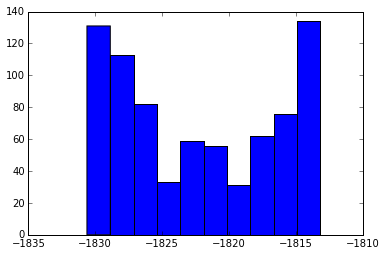

In [19]:
plt.hist(t['yan_raw_compare'][0][0])

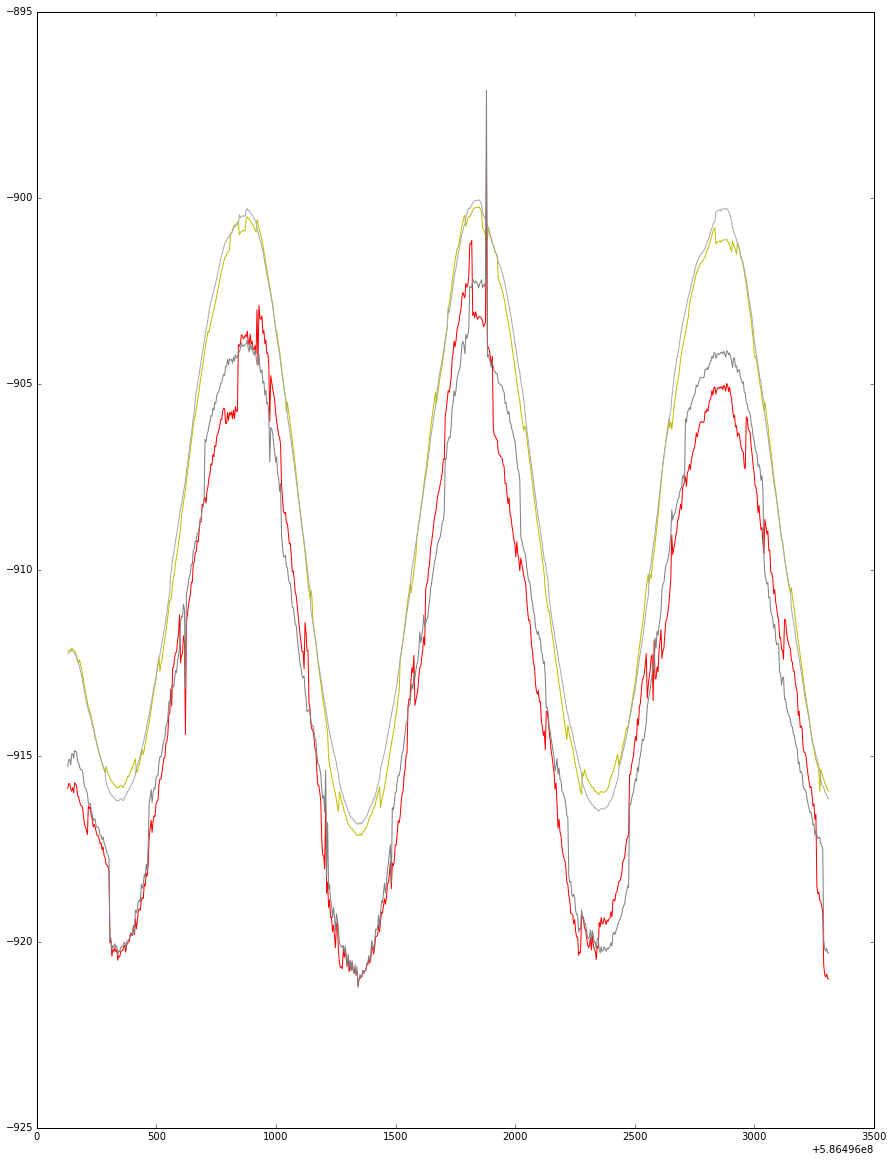

In [20]:
fig = plt.figure(figsize=(15, 20))
plt.plot(t['time'][4], t['yan_raw'][4][0] - 2195, color='y')
plt.plot(t['time'][4], t['yan_raw'][7][0], color='r')
plt.plot(t['time'][4], t['yan_raw_compare'][4][0] - 2195, color='darkgray')
plt.plot(t['time'][4], t['yan_raw_compare'][7][0], color='gray')

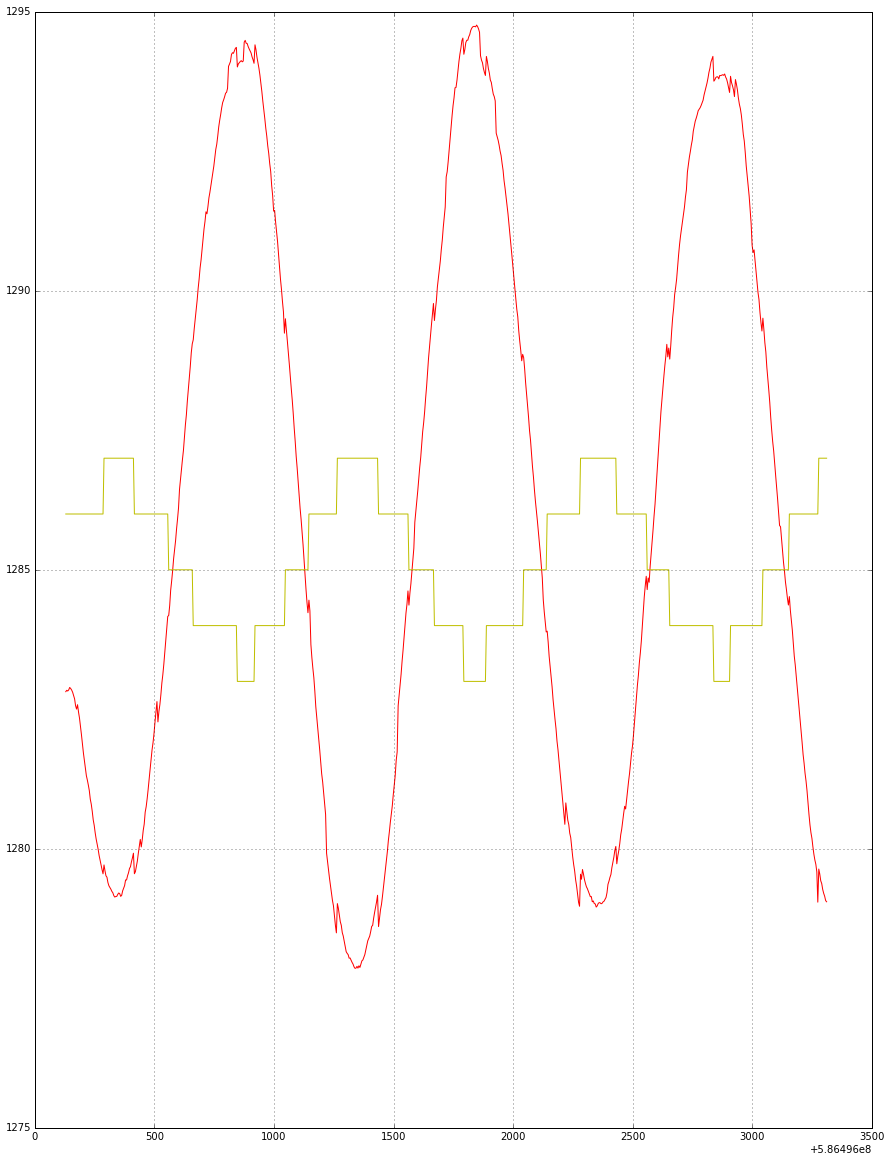

In [28]:
fig = plt.figure(figsize=(15, 20))
#plt.plot(t['row0'][4], t['yan_resids'][4][0][0], color='y')
plt.plot(t['time'][4], t['yan_raw'][4][0], color='r')
plt.plot(t['time'][4], t['row0'][4] + 1540, color='y')
plt.grid(b=True)

In [29]:
# Plotting functions

def plot_resids(t, txt=''):
    fig = plt.figure(figsize=(10, 20))

    for slot in slots:
        for key in ['yan', 'zan']:
            plt.subplot(4, 2, slot + 1)
            plt.plot(t['time'][slot], t[key + '_resids' + txt][slot][0][0],
                     label='{}, std = {:.3f}'.format(key, t['{}_stds'.format(key) + txt][slot][0]))

        plt.ylim(-0.052, 0.052)
        plt.legend()
        plt.title("obsid {}, slot {}".format(obsid, slot))
        plt.ylabel("Resid (arcsec)")
        plt.xlabel("Time (sec)")

    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.3)
    return


def plot_d_ang(key, dt, t1, t2=None):
    # plot delta yan(or zan)
    ylim = [(76, 82), (2272, 2278)]
    fig = plt.figure(figsize=(10, 20))
    
    if t2 is None:
        t2 = t1
    
    for i, slot in enumerate([4, 7]):
        plt.subplot(4, 2, i + 1)
        ang_interp = Ska.Numpy.interpolate(t2[key][slot][0], t2['time'][slot] + dt[i],
                                           t1['time'][2],
                                           method="nearest")
        d_ang = t1[key][2][0] - ang_interp
        plt.plot(t1['time'][2], d_ang, color='Darkorange',
                 label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
        plt.plot(t1['time'][2], t1['row0'][2], color='y')
        plt.plot(t1['time'][2], t1['row0'][slot], color='darkorange')
        plt.ylim(ylim[i])
        plt.xlabel('Time (sec)')
        plt.ylabel('delta {} (arcsec)'.format(key))
        plt.title('Slot 2 - Slot {}'.format(slot))
        plt.legend()

    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.3)
    return

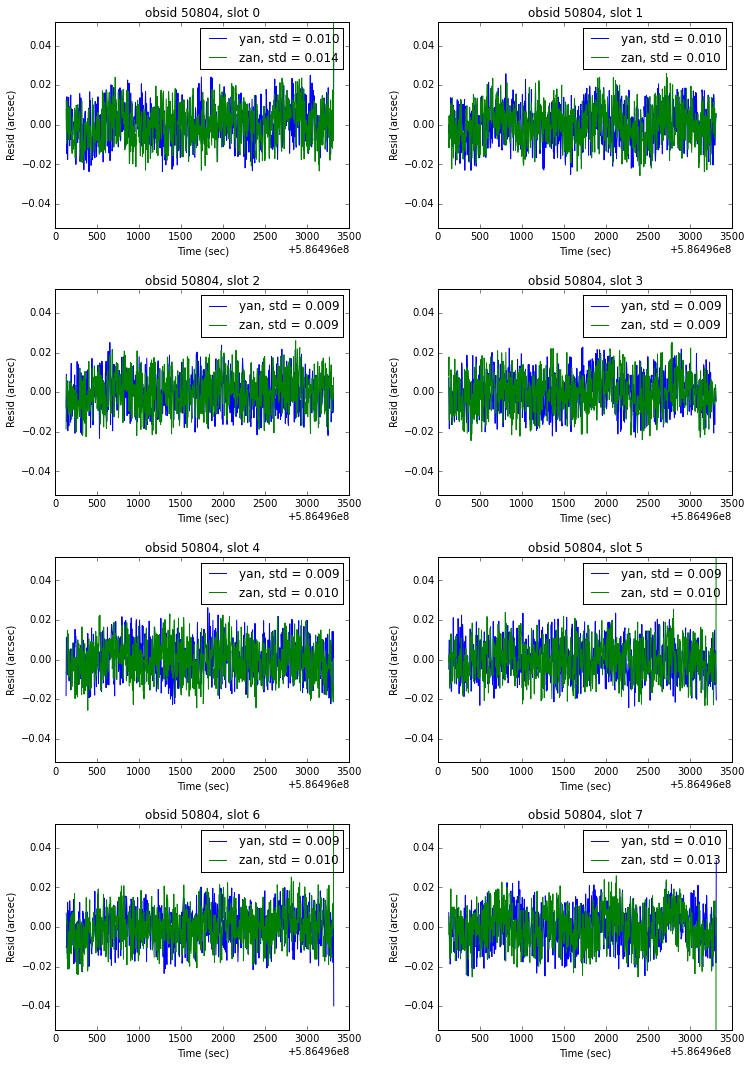

In [45]:
plot_resids(t, '_compare')

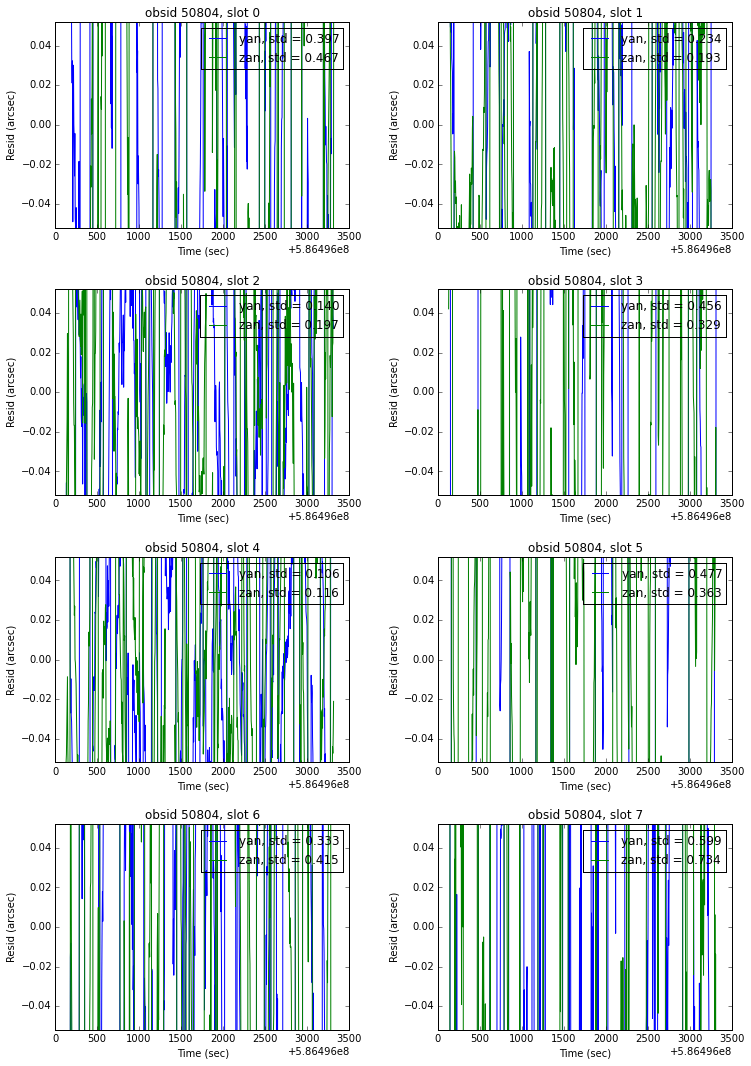

In [94]:
plot_resids(t)

In [31]:
print (t['time'][2] - t['time'][4])[:5]
print (t['time'][2] - t['time'][7])[:5]
dt = [0, -2.05] # shift in sec between time axes for slot pairs (2, 4) and (2, 7)

#print (t['time'][2] - t['time'][5])[:5]
#print (t['time'][2] - t['time'][6])[:5]
#dt = [-2.05, -2.05] # shift in sec between time axes for slot pairs (2, 5) and (2, 6)

[ 0.  0.  0.  0.  0.]
[-2.05000019 -2.04999995 -2.05000019 -2.05000019 -2.04999995]


Method: dark current map subtraction


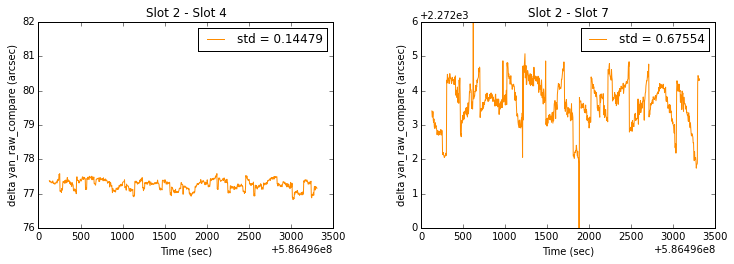

In [32]:
key = 'yan_raw_compare'
plot_d_ang(key, dt, t)
print "Method: dark current map subtraction"

Method: dark current map subtraction


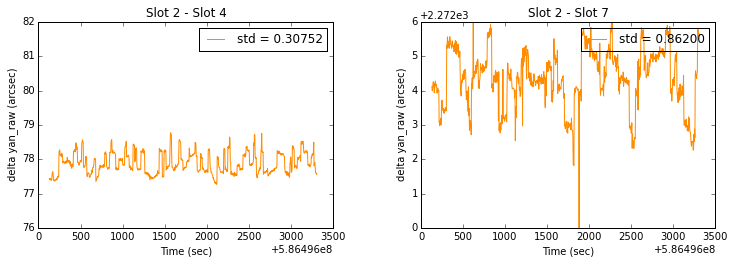

In [33]:
key = 'yan_raw'
plot_d_ang(key, dt, t)
print "Method: dark current map subtraction"

### Tests ###

__Row and Col coordinates__

In [ ]:
# Recall:
r = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 
     6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7,
     2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5]
c = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
     0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
     0, 0, 0, 0, 1, 1, 1, 1, 6, 6, 6, 6, 7, 7, 7, 7]

rin = [2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5]
cin = [2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5]

#
#      (1)--->
#  (3) XXXXXXXX (4)
#   |  XXXXXXXX  |
#   |/ XX....XX  |/
#      XX....XX
#      XX....XX
#      XX....XX
#      XXXXXXXX
#      XXXXXXXX
#      (2)--->

In [ ]:
# Definition of (r, c) coordinates

slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=3)
raw_image = slot_data['IMGRAW'][0]

print 'Raw image:'
print raw_image
print
print "Raw image (reshaped):"
print raw_image.reshape(8, 8, order='F')
print
for rr, cc in zip(r, c):
    print "(r, c) = ({}, {}): {}".format(rr, cc, raw_image.reshape(8, 8, order='F')[rr, cc])

 __edge_pixels_dict_8x8__

In [ ]:
slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=3)
frame_data = slot_data[7:8]

raw_image = frame_data['IMGRAW'][0]
row0 = frame_data['IMGROW0'][0]
col0 = frame_data['IMGCOL0'][0]

edge_pixels_dict = edge_pixels_dict_8x8(raw_image, row0, col0)

print "Raw image (reshaped):"
print raw_image.reshape(8, 8, order='F')
print
print "Row0, Col0 = {}, {}".format(row0, col0)
print
rr = row0 + shift
cc = col0 + shift
print "Row, Col in 1024x1024 = {}, {}".format(rr, cc)
print
print "edge_pixels_dict:"
print edge_pixels_dict
print
print "Verify some edge values:"
print
print "Upper left = {}".format(edge_pixels_dict['{}.{}'.format(rr, cc)])
print "Upper right = {}".format(edge_pixels_dict['{}.{}'.format(rr, cc + 7)])
print "Lower left = {}".format(edge_pixels_dict['{}.{}'.format(rr + 7, cc)])
print "Lower right = {}".format(edge_pixels_dict['{}.{}'.format(rr + 7, cc + 7)])
print "Row 2, Col 0 = {}".format(edge_pixels_dict['{}.{}'.format(rr + 2, cc)])
print "Row 7, Col 6 = {}".format(edge_pixels_dict['{}.{}'.format(rr + 7, cc + 6)])

In [ ]:
def test_1(key, coords, deque_dict, frame_row):
    print "T1: Key = ", key
    print "T1: Frame edge keys = ", frame_row['edge_vals'].keys()
    print "T1: Frame row0, col0 (shifted) = ", frame_row['row0'] + shift, frame_row['col0'] + shift
    print "T1: dict_deque[key] = ", deque_dict[key]
    print
    return


def test_2(ii, coords, deque_dict, median_dict, frame_row):
    print 'T2: Index = {}'.format(ii)
    print 'T2: Deque_dict size = {}'.format(len(deque_dict))
    for r in range(coords.rstart, coords.rend):
        keys = ['{}.{}'.format(r, cc) for cc in range(coords.cstart, coords.cend)]
        print 'T2: Keys: '
        print keys
        print "T2: Deque_dict:"
        vals = [deque_dict[key] for key in keys]
        print vals
        print "T2: Median_dict:"
        vals = [median_dict[key] for key in keys]
        print vals
        print
    
    # Reshape median_dict
    print "T2: Median reshaped:"
    print np.array(median_dict.values()).reshape(coords.dr, coords.dc)
    return